In [1]:
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns
import datetime
from lib.utils import sql_from_cache, year, sem
pd.set_option('display.max_rows',100)


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Carregar os dados processados.

## Matriculas em cursos
Cada Unidade da USP tem um ou mais cursos e cada ano um aluno pode estar matriculado num curso. Fiz um processamento de uma tabela do Júpiter chamado SITALUNOATIVOGR, uma consolidação de dados de outras tabelas.

Para cada ano / semestre, contem todas as matriculas em cursos de graduação, uma linha por pessoa. Mas não podemos divulgar dados de alunos individuais, e agregei a tabela por unidade, curso, habilitação e status da matrícula. Veja:

In [3]:
cursos = pd.read_csv('data/processed/matrcurso.csv')
unidade = "IF"
ano = 2020
cursos.query("sglund == @unidade & ano == @ano")[:10]

,ano,sem,codclg,codcur,codhab,staalu,codund,sglund,nomcur,nomhab,matr
11958,2020,1,43,43020,101,M,43,IF,Física Bacharelado,Física Bacharelado,9
11959,2020,1,43,43020,101,T,43,IF,Física Bacharelado,Física Bacharelado,3
11960,2020,1,43,43020,104,M,43,IF,Física Bacharelado,Física Bacharelado,15
11961,2020,1,43,43020,104,T,43,IF,Física Bacharelado,Física Bacharelado,3
11962,2020,1,43,43021,101,A,43,IF,Física Bacharelado,Física Bacharelado,4
11963,2020,1,43,43021,101,M,43,IF,Física Bacharelado,Física Bacharelado,313
11964,2020,1,43,43021,101,T,43,IF,Física Bacharelado,Física Bacharelado,22
11965,2020,1,43,43021,104,A,43,IF,Física Bacharelado,Física Bacharelado,8
11966,2020,1,43,43021,104,M,43,IF,Física Bacharelado,Física Bacharelado,403
11967,2020,1,43,43021,104,R,43,IF,Física Bacharelado,Física Bacharelado,3


Segundo a documentação, o campo staalu (status do aluno) "Indica a situação do aluno ativo no ano/semestre: Matriculado (M), Trancado (T), Suspenso (S), Pendente (P), Ativo (A) ou Reativado(R). Ativo ou Reativado indicam que o aluno não está matriculado neste semestre."

Acho que a primeira coisa interessante a fazer é ver o número de matriculados por unidade da USP

<AxesSubplot:xlabel='matr', ylabel='sglund'>

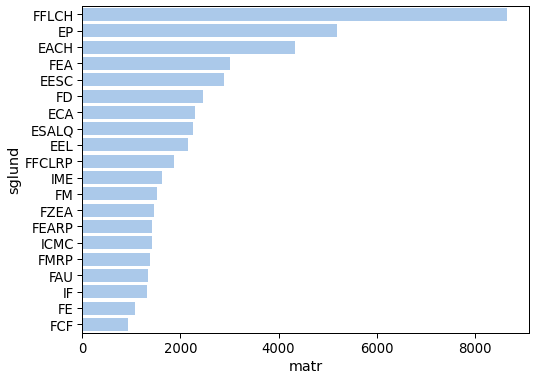

In [4]:
sns.set_context('paper',font_scale=1.5)
fig = plt.figure(figsize=(8,6))
ano = 2020
N = 20
sns.set_color_codes("pastel")
data = cursos.query("ano == @ano & staalu == 'M'")
order = data.groupby('sglund')['matr'].sum().sort_values(ascending=False).index[:N]
sns.barplot(data=data,y='sglund',x='matr',estimator=np.sum,ci=False,order=order,color='b')

In [11]:
disc = pd.read_csv('data/processed/disc.csv') #matriculas em disciplinas
mc = pd.read_csv('data/nonpublic/mc.csv')
# pandas reclama: DtypeWarning: Columns (53) have mixed types. Paciência https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.errors.DtypeWarning.html
mc_filtered = mc[~((mc['N'] ==1) & (mc['forum'] ==1))]
mc_filtered = mc_filtered[mc_filtered['posgrad'].isin(['GR','POS'])]
mc_filtered = mc_filtered.query("area != '0'")
# Só um fórum,  deve ser o de Avisos. TODO: talvez o Fórum Avisos está sendo usado...

/opt/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (56) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
mc_filtered.area.value_counts(dropna=True)

humanas       14072
exatas        11557
biologicas     7403
Name: area, dtype: int64

## Ambientes de apoio e Módulos por unidade, area, ano etc.
Agora temos um dataframe, `mc` e `mc_filtered` com uma linha por ambiente, com número de cada módulo, unidade, número de matriculados e docentes. Primeiro, vamos ver a evolução da "adoção". Provavelmente o indicador mais relevante é o número de matrículas (efetivamente dando mais peso para disciplinas com mais matriculados). 

[Há um problema: se agregar por ano, 2020.1 não pode ser plottado facilmente... Se usar o semestre, somente temos disciplinas de graduação. ]

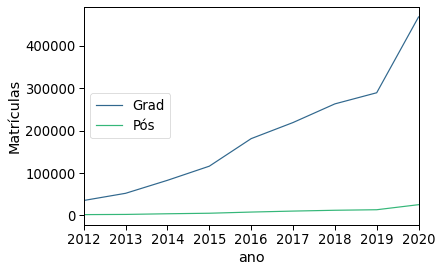

In [14]:
palette = sns.color_palette('viridis',n_colors=2)
sns.lineplot(data=mc_filtered,x='ano',y='student',estimator=np.sum,ci=None,hue='posgrad',palette=palette)
ax=plt.gca()
#ax.hlines([19700,4527],2015,2017,colors=[palette[0],palette[1]],linestyles='dashed')
ax.set_xlim(2012,2020)
#ax.set_ylim(0,20000)
ax.set_ylabel("Matrículas")
ax.legend(["Grad","Pós"],loc='center left',ncol=1);

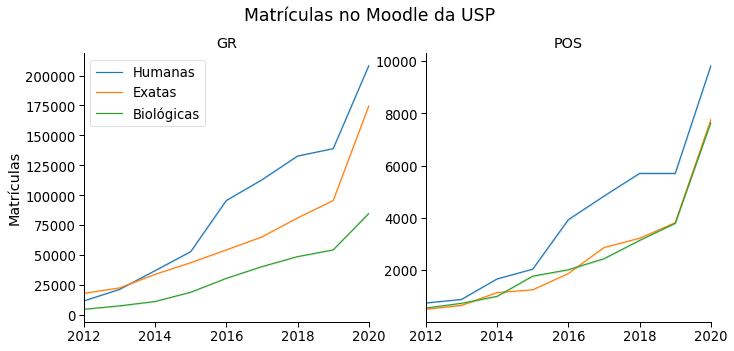

In [15]:
sns.set_context('paper',font_scale=1.5)
g = sns.relplot(data=mc_filtered,x='ano',y='student',kind='line',estimator=np.sum,ci=False,hue='area',col='posgrad',facet_kws={'sharey':False},legend=False)
g.set_ylabels('Matrículas')
g.set_xlabels("")
g.set(xlim=(2012,2020))
g.fig.suptitle("Matrículas no Moodle da USP")
plt.subplots_adjust(top=0.85,wspace=0.2)
g.set_titles(template="{col_name}")
g.axes[0,0].legend(['Humanas','Exatas',"Biológicas"],loc='upper left');

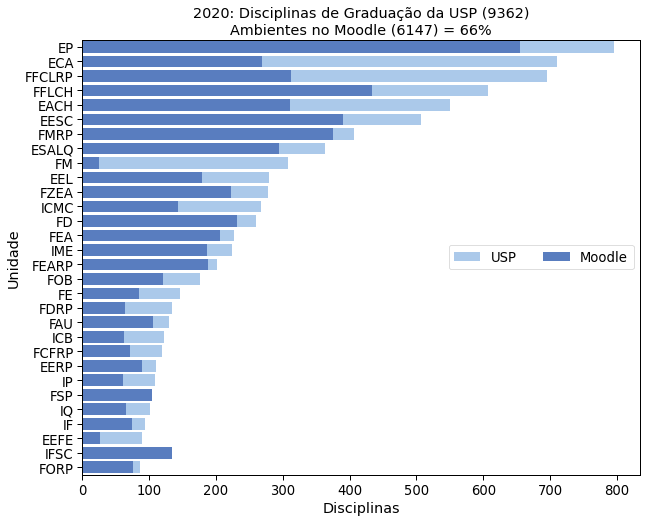

In [16]:
ano = 2020
data = mc[mc['ano'] == ano]
data = data[data.posgrad == 'GR']
sns.set_context('paper',font_scale=1.5)
N = 30
data = data.groupby('coddis',as_index=False).agg({'student':'sum','unidade':'first'})

fig = plt.figure(figsize=(10,8))
order = disc.query("ano == @ano").groupby('unidade')['coddis'].count().sort_values(ascending=False).index[:N]
sns.set_color_codes("pastel")
sns.countplot(data=disc.query("ano == @ano"),y='unidade',order=order,color = 'b',label = 'USP')
sns.set_color_codes("muted")
sns.countplot(data=data,y='unidade',order=order,color = 'b',label = 'Moodle')
ax = plt.gca()
ax.legend(ncol=2, loc="center right", frameon=True)
ax.set_ylabel("Unidade")
ax.set_xlabel("Disciplinas")
Ndisc = len(disc.query("ano == @ano"))
Nmoodle = len(data)
frac = Nmoodle/Ndisc
ax.set_title("{}: Disciplinas de Graduação da USP ({})\nAmbientes no Moodle ({}) = {:0.0f}%".format(ano,Ndisc,Nmoodle,frac*100));

Matriculas da USP (2020): 672972. Matriculas no Moodle da USP: 467910. Fração: 0.70


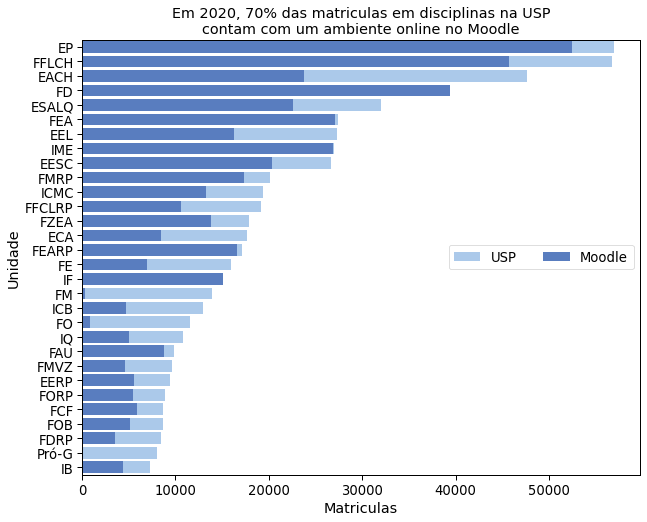

In [18]:
ano = 2020
data = mc_filtered[(mc_filtered.posgrad == 'GR') & (mc_filtered['ano'] == ano)]
sns.set_context('paper',font_scale=1.5)
N = 30
order = disc.query("ano == @ano").groupby('unidade')['matr'].sum().sort_values(ascending=False).index[:N]   
data = data.groupby('coddis',as_index=False).agg({'student':'sum','unidade':'first'})
Nmatr = data.student.sum()
Nmatr18 = disc.query("ano == @ano").matr.sum()
frac = Nmatr/Nmatr18
print("Matriculas da USP ({}): {}. Matriculas no Moodle da USP: {}. Fração: {:0.2f}".format(ano,Nmatr18,Nmatr,frac))
fig = plt.figure(figsize=(10,8))
sns.set_color_codes("pastel")
sns.barplot(data=disc.query("ano == @ano"),x='matr',y='unidade',estimator=np.sum,ci=False,order=order,color = 'b',label = 'USP')
sns.set_color_codes("muted")
sns.barplot(data=data,x='student',y='unidade',estimator=np.sum,ci=False,order=order,color = 'b', label = 'Moodle')
ax=plt.gca()
ax.legend(ncol=2, loc="center right", frameon=True)
ax.set_ylabel("Unidade")
ax.set_xlabel("Matriculas")
ax.set_title("Em {}, {:.0f}% das matriculas em disciplinas na USP\ncontam com um ambiente online no Moodle".format(ano,frac*100))
fn = 'figs/matr-{}.png'.format(ano)
plt.savefig(fn,dpi=300)

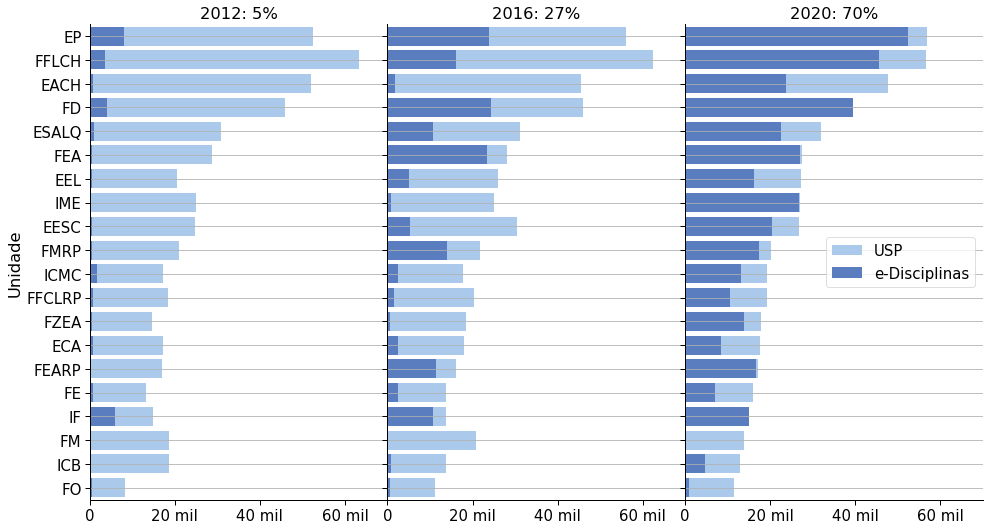

In [22]:
sns.set_context('paper',font_scale=1.7)
N = 20
anos =[2012,2016,2020]
fig,axs = plt.subplots(1,len(anos),sharey=False,figsize=(16,8))
order = disc[disc['ano'] == 2020].groupby('unidade')['matr'].sum().sort_values(ascending=False).index[:N]


def matfig(ano,ax):
    
    data = mc_filtered[(mc_filtered.posgrad == 'GR') & (mc_filtered.ano == ano)]
    data = data.groupby('coddis',as_index=False).agg({'student':'sum','unidade':'first'})
    uspdata = disc[disc.ano == ano]
    Nmatr = data.student.sum()
    Nmatrusp = uspdata.matr.sum()
    frac = Nmatr/Nmatrusp
    sns.set_color_codes("pastel")
    sns.barplot(data=uspdata,x='matr',y='unidade',estimator=np.sum,ci=False,order=order,color = 'b',label = 'USP',ax=ax)
    sns.set_color_codes("muted")
    sns.barplot(data=data,x='student',y='unidade',estimator=np.sum,ci=False,order=order,color = 'b', label = 'e-Disciplinas',ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0,70000)
    ax.yaxis.grid(True);
    ax.set_xticks([0,20000,40000,60000])
    ax.set_xticklabels(['0','20 mil','40 mil','60 mil'])
    ax.set_yticklabels('')
    if(ano == 2020):
        ano = '2020'
    ax.set_title("{}: {:.0f}%".format(ano,frac*100))
    
for ax,ano in zip(axs,anos):
    matfig(ano,ax)


axs[2].legend(ncol=1, loc="center right", frameon=True)
axs[0].set_ylabel("Unidade")
axs[0].set_yticklabels(order)
plt.subplots_adjust(top=0.95,wspace=0)
#fig.suptitle("Matriculas da USP e no Moodle da USP (Graduação)")
plt.savefig('figs/matriculas-moodle-por-unidade.jpg',dpi=300)
sns.despine()

In [4]:
mc.columns

Index(['index', 'link', 'assign', 'attendance', 'bigbluebuttonbn', 'book',
       'chat', 'choice', 'data', 'dialogue', 'folder', 'forum', 'glossary',
       'imscp', 'label', 'lesson', 'lti', 'oublog', 'ouwiki', 'page',
       'questionnaire', 'quiz', 'recordingsbn', 'resource', 'scorm', 'survey',
       'url', 'wiki', 'workshop', 'sdi', 'Nunique', 'N', 'Nresource1',
       'Nresource2', 'Ncommunication', 'Nfeedback', 'Nassess', 'Nadmin',
       'fullname', 'shortname', 'idnumber', 'catname', 'unidade', 'ano', 'sem',
       'advancedteacher', 'editingteacher', 'manager', 'monitor', 'student',
       'studentcopy', 'teacher', 'nturmas', 'area', 'posgrad', 'coddis',
       'semestre', 'activequiz', 'assignment', 'hvp', 'simplecertificate',
       'videogallery', 'choicegroup', 'scheduler', 'vpl', 'offlinequiz', 'obs',
       'poster', 'feedback', 'journal', 'checklist', 'pdfannotator',
       'publication', 'studentquiz'],
      dtype='object')

In [8]:
mc = pd.read_csv('data/processed/mc.csv',usecols=[ 'ano','index','sdi','Nunique','N',
                                                  'fullname', 'shortname', 'idnumber', 'catname', 'unidade',
                                                  'Nresource1','Nresource2','Ncommunication','Nfeedback', 'Nassess', 'Nadmin',
                                                  'editingteacher', 'monitor', 'student', 'teacher', 'nturmas', 
                                                  'area', 'posgrad', 'coddis','semestre'])
mc[:2]

/opt/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (56) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,index,sdi,Nunique,N,Nresource1,Nresource2,Ncommunication,Nfeedback,Nassess,Nadmin,...,ano,editingteacher,monitor,student,teacher,nturmas,area,posgrad,coddis,semestre
0,5,1.732052,10,81,41,29,1,2,8,0,...,2012,1,6,30,0,2,humanas,GR,CBD0274,1
1,6,1.381154,8,29,21,0,1,1,6,0,...,2012,1,5,38,0,2,humanas,GR,CBD0286,1


In [13]:
mc.groupby(['ano','unidade']).agg({'index': 'count','student': 'sum'}).loc[2019]

,index,student
unidade,,
CENA,7,182
EACH,176,10097
ECA,197,5127
EE,38,2079
EEFE,25,1237
EEFERP,43,2214
EEL,200,10751
EERP,139,5620
EESC,456,15824
